In [1]:
import os
import numpy as np
from IPython.display import HTML
import string
import nltk
import re
import random

from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
from nltk.tokenize import TweetTokenizer

from HMM import unsupervised_HMM
from HMM_helper import (
    text_to_wordcloud,
    states_to_wordclouds,
    parse_observations,
    obs_map_reverser,
    sample_sentence,
    sample_sentence_backwards,
    visualize_sparsities,
    animate_emission
)

# Download Data

In [2]:
nltk.download('wordnet') 
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
text = open(os.path.join(os.getcwd(), 'data/shakespeare.txt')).read()

In [4]:
# syllable dictionary
# format the syllable dictionary
syll_dict = open(os.path.join(os.getcwd(), 'data/Syllable_dictionary.txt')).read()
syll_dict = syll_dict.splitlines()
syll_dict2 = []
for i in range(len(syll_dict)):
    syll_dict2.append(syll_dict[i].split())
syll_dict = syll_dict2

# Pre-processing

## Create obs and obs_map

In [5]:
# remove numbers denoting each sonnet
# remove capitalization
# remove apostrophes that are suffixes to a word, not part of the word

def text_lowercase(text): 
    return text.lower() 

def remove_numbers(text): 
    result = re.sub(r'\d+', '', text) 
    return result 

def remove_punctuation(text): 
    punctuation_set = ':' + ';' + ',' + '.' + '!' + '?' + '(' + ')'
    translator = str.maketrans('', '', punctuation_set)
    return text.translate(translator).replace("' ", " ")

lemmatizer = WordNetLemmatizer() 
tknzr = TweetTokenizer()
def lemmatize_word(text): 
    word_tokens = tknzr.tokenize(text) 
    # provide context i.e. part-of-speech 
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
    return lemmas 

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    # convert text to integers
    for line in lines:
        obs_elem = []
        
        for word in line:
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

# create new tokenized data and observation mapping
obs, obs_map = parse_observations(text_lowercase(remove_punctuation(remove_numbers(text))))

## Create Rhyming Dictionary

In [6]:
# read in data and remove blank lines
data = text.splitlines()
data = [string for string in data if string != ""]
poems = []
poem = []

# remove sonnet numbers and append each poem to list poems
for line in data:
    stripped = line.strip()
    if stripped.isdigit():
        if stripped != '1':
            poems.append(poem)
            poem = []
    else:
        poem.append(remove_punctuation(stripped))

# append final poem
poems.append(poem)

# remove poems that are not exactly 14 lines long
i = 1
for p in poems:
    i+=1
    if len(p) != 14:
        poems.remove(p)

# create rhyming dictionary, where each key is a word that was the last in a line,
# and the values are all the words that Shakespeare used to rhyme with the key word.
rhyme_dict = {}
for poem in poems:
    for i, line in enumerate(poem):
        # rhyme scheme is abab cdcd efef gg
        if i == 0 or i == 1 or i == 4 or i == 5 or i == 8 or i == 9:
            # look at last words of each line
            word1 = poem[i].split(' ')[-1]
            word2 = poem[i+2].split(' ')[-1]
            # add rhyming words to dictionary
            if word1 in rhyme_dict:
                if not word2 in rhyme_dict[word1]:
                    rhyme_dict[word1].append(word2)
            else:
                rhyme_dict[word1] = [word2]
                
            # add words in opposite order too
            if word2 in rhyme_dict:
                if not word1 in rhyme_dict[word2]:
                    rhyme_dict[word2].append(word1)
            else:
                rhyme_dict[word2] = [word1]
        elif i == 12:
            # look at last words of each line
            word1 = poem[i].split(' ')[-1]
            word2 = poem[i+1].split(' ')[-1]
            
            # add rhyming words to dictionary
            if word1 in rhyme_dict:
                if not word2 in rhyme_dict[word1]:
                    rhyme_dict[word1].append(word2)
            else:
                rhyme_dict[word1] = [word2]
            
            # add words in opposite order too
            if word2 in rhyme_dict:
                if not word1 in rhyme_dict[word2]:
                    rhyme_dict[word2].append(word1)
            else:
                rhyme_dict[word2] = [word1]

# Training

In [7]:
hmm10 = unsupervised_HMM(obs, 10, 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


# Naive HMM Generation

In [14]:
# generate 14 line sonnet naively with trained HMM
for i in range(14):
    # use 8 words per line as an average
    sentence = sample_sentence(hmm10, obs_map, 8)[0:-3]
    print(sentence)

Time again each love heaven bind unless crowned
What be it am is glad so blame
Weep and parts in painted to grief i
Free write he shall was shall the on
In call bosom bright shalt he old i
Most time i them with the glory time
And much their verse hath the his day
Treads field dost with the to but all-oblivious
When their churl beast me fear light not
Flies his soundless sheds her long on can
Of not heart but bind takes name as
And ruined but nothing own beauty decay on
Dearth pretty lie your self and time i
Which never welcome is call doth mercy is


## Generate sonnets with 10 syllables per line

In [17]:
syllables = 0
i = 0
num_lines = 0
poem = ''
add_last_syll = 0

while num_lines < 14: # ensure it's 14 lines in total
    # generate 10 words cuz 10 syllables/line. might not use all 10 words
    string = sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower() 
    syllables = 0
    i = 0
    line = ''
    add_last_syll = 0
    
    # generates one line
    while syllables < 10:
        word = string.split()[i]
        index = [i[0] for i in syll_dict].index(word)
        add_syll = int(syll_dict[index][-1])
        # special case for last word. ref. to syllable_dictionary.txt
        if np.shape(syll_dict[index]) == 3:
            add_last_syll = int(syll_dict[index].split()[1][1][1])
        # if last word is a special case
        if syllables + add_last_syll == 10:
            line += word
            syllables += add_last_syll
        # normal cases
        elif syllables + add_syll <= 10:
            line += word + ' '
            syllables += add_syll
            add_last_syll = 0
        # no. of syllables of last word would cause line to exceed 10 syllables. redo the whole line.
        else: 
            string = sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower() # regenerate string
            syllables = 0
            i = -1
            line = ''
            add_last_syll = 0
        i += 1
    num_lines += 1
    poem += line.capitalize() + "\n"
print(poem)


Days mine men counted himself as thou shalt 
What dearly the and frowns are he wherefore 
Is that feeds and and it for creature this 
Would only sea in and my woe clear faint 
Their not so decay supposed burthens 
Abundance thine see guess sinks there body's 
Not art the the his the ever by hate 
Thee my dulness eyes that every to his 
Life who thou i cloud willing change thy feel 
Store as self art best infection is on 
Thunder than happy but thy thoughts do this 
Things the it that being your days doth your 
So for cheek not awake to thy songs and 
I for times needs doubt my thee thine me hold 



## Generate sonnets that follow rhyming scheme

In [18]:
poem = []
for i in range(14):
    poem.append('')

# generate 14 lined sonnet
for i in range(14):
    # seed lines with random rhyming word
    rand = random.randint(0,len(rhyme_dict)-1)
    word1 = list(rhyme_dict.keys())[rand]
    words = rhyme_dict[word1]
    word2 = words[random.randint(0,len(words)-1)]

    ind1 = obs_map[word1.lower()]
    ind2 = obs_map[word2.lower()]
    # generate 8 words backwards, seeding with the rhyming words
    line = sample_sentence_backwards(hmm10, obs_map, 7, ind1)[0:-3]
    line2 = sample_sentence_backwards(hmm10, obs_map, 7, ind2)[0:-3]
    if i == 0 or i == 1 or i == 4 or i == 5 or i == 8 or i == 9:
        poem[i] = line
        poem[i+2] = line2
    if i == 12:
        poem[i] = line
        poem[i+1] = line2

for l in poem: 
    print(l)

Praised writers own o and like die
From love not i siege of knights
Dost outlive shame i heaven merchandized lie
Shall whilst from keeps age the wights
He in what's you of of bed
Then have sweet eyes of my account
Be weep can make others they head
You for are it how or surmount
Of gay lose and make am require
Gracious foot in uphold famished with meet
Glory and mad me thy you desire
Let lives false thy it gone sweet
Than how show speak thy that bower
Than yet excellence is have thee power


## Generate sonnets that follow rhyming scheme and have 10 syllables per line

In [19]:
syllables = 0
i = 0
num_lines = 0
poem = []
for j in range(14):
    poem.append('')
add_last_syll = 0

for k in range(14):
    # seed lines with random rhyming words
    rand = random.randint(0,len(rhyme_dict)-1)
    word1 = list(rhyme_dict.keys())[rand]
    words = rhyme_dict[word1]
    word2 = words[random.randint(0,len(words)-1)]
    ind1 = obs_map[word1.lower()]
    ind2 = obs_map[word2.lower()]
    
    # generate reversed sentences so rhyming word doesn't get truncated
    # generate line for rhyming word 1
    string = sample_sentence_backwards(hmm10, obs_map, n_words=10, start_state=ind1)[0:-3].lower()
    string = ' '.join(string.split()[::-1])
    syllables = 0
    i = 0
    line = ''
    add_last_syll = 0
    # generates one line
    while syllables < 10:
        word = string.split()[i]
        index = [i[0] for i in syll_dict].index(word)
        add_syll = int(syll_dict[index][-1])
        if np.shape(syll_dict[index]) == 3: # special case for last word
            add_last_syll = int(syll_dict[index].split()[1][1][1])
        
        if syllables + add_last_syll == 10:
            line += word
            syllables += add_last_syll
        elif syllables + add_syll <= 10:
            line += word + ' '
            syllables += add_syll
            add_last_syll = 0
        else: # regenerate string
            string = sample_sentence_backwards(hmm10, obs_map, n_words=10, start_state=ind1)[0:-3].lower()
            string = ' '.join(string.split()[::-1])
            syllables = 0
            i = -1
            line = ''
            add_last_syll = 0
        i += 1
    
    # generate line for rhyming word 2
    string2 = sample_sentence_backwards(hmm10, obs_map, n_words=10, start_state=ind2)[0:-3].lower()
    string2 = ' '.join(string2.split()[::-1])
    syllables = 0
    i = 0
    line2 = ''
    add_last_syll = 0
    # generates one line
    while syllables < 10:
        word = string2.split()[i]
        index = [i[0] for i in syll_dict].index(word)
        add_syll = int(syll_dict[index][-1])
        if np.shape(syll_dict[index]) == 3: # special case for last word
            add_last_syll = int(syll_dict[index].split()[1][1][1])
        
        if syllables + add_last_syll == 10:
            line2 += word
            syllables += add_last_syll
        elif syllables + add_syll <= 10:
            line2 += word + ' '
            syllables += add_syll
            add_last_syll = 0
        else: # regenerate string
            string2 = sample_sentence_backwards(hmm10, obs_map, n_words=10, start_state=ind2)[0:-3].lower()
            string2 = ' '.join(string2.split()[::-1])
            syllables = 0
            i = -1
            line2 = ''
            add_last_syll = 0
        i += 1

    # reverse lines so that rhyming words are at the end
    line = ' '.join(line.split()[::-1])
    line2 = ' '.join(line2.split()[::-1])
    
    # append lines to follow correct rhyme scheme
    if k == 0 or k == 1 or k == 4 or k == 5 or k == 8 or k == 9:
        poem[k] = line.capitalize()
        poem[k+2] = line2.capitalize()
    if k == 12:
        poem[k] = line.capitalize()
        poem[k+1] = line2.capitalize()
        
    num_lines += 1

for l in poem: 
    print(l)

Found these hateth make a cheek appetite
That to desire know lives is respect prone
Thy image respect in my the should might
Praise on who sue of good dispatch alone
Blood thine for from their so cannot leaves steep
Ill those what seem verse contain looking smoke
Being look as thy whom i mind asleep
Not glass to weary the sum would my cloak
Sway me alien every my say subsist
Tongue truth then outlive by and their awake
Am found of her you seen silent am missed
No then work of paying most then from sake
Upon cunning art greater from strive thine
Bear from these none i men death and one shine


## Generate Haiku

In [20]:
syllables = 0
i = 0
num_lines = 0
poem = ''
add_last_syll = 0

# generate only 3 lines, with 5, 7, 5 syllables, respectively
while num_lines < 3:
    string = sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower()
    syllables = 0
    i = 0
    line = ''
    add_last_syll = 0
    num_syll = 5
    if num_lines == 1:
        num_syll = 7
    # generates one line
    while syllables < num_syll:
        word = string.split()[i]
        index = [i[0] for i in syll_dict].index(word)
        add_syll = int(syll_dict[index][-1])
        if np.shape(syll_dict[index]) == 3: # special case for last word
            add_last_syll = int(syll_dict[index].split()[1][1][1])
        
        if syllables + add_last_syll == num_syll:
            line += word
            syllables += add_last_syll
        elif syllables + add_syll <= num_syll:
            line += word + ' '
            syllables += add_syll
            add_last_syll = 0
        else: # regenerate string
            string = sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower()
            syllables = 0
            i = -1
            line = ''
            add_last_syll = 0
        i += 1
    num_lines += 1
    poem += line.capitalize() + "\n"
print(poem)

Beauty by is am 
Were so know'st thy blame me when 
That and you shadows 



# Create visualizations of transition and observation matrices

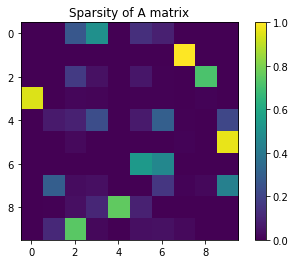

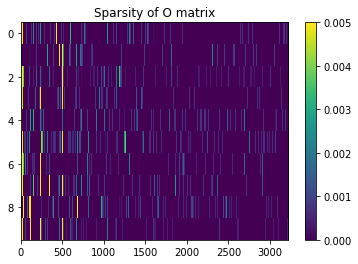

For state  0 , the most popular words are:  ['as', 'art', 'so', 'if', 'a', 'when', 'that', 'dost', 'on', 'from']
For state  1 , the most popular words are:  ['and', 'to', 'but', 'for', 'when', 'in', 'though', 'or', 'if', 'which']
For state  2 , the most popular words are:  ['my', 'thy', 'i', 'your', 'not', 'of', 'in', 'that', 'mine', 'their']
For state  3 , the most popular words are:  ['thou', 'to', 'not', 'thy', 'but', 'no', 'me', 'so', 'doth', 'for']
For state  4 , the most popular words are:  ['and', 'is', 'that', 'in', 'for', 'or', 'but', 'when', 'than', 'to']
For state  5 , the most popular words are:  ['i', 'with', 'is', 'in', 'to', 'you', 'time', 'and', 'beauty', 'which']
For state  6 , the most popular words are:  ['the', 'that', 'his', 'to', 'with', 'a', 'by', 'my', 'some', 'nor']
For state  7 , the most popular words are:  ['i', 'in', 'all', 'you', 'that', 'me', 'yet', 'for', 'then', 'be']
For state  8 , the most popular words are:  ['love', 'the', 'self', 'heart', 'so', 'am

In [21]:

visualize_sparsities(hmm10,len(hmm10.O[0]),0.005)
obs_map_r = obs_map_reverser(obs_map)
for i in range(len(hmm10.O)):
    row = hmm10.O[i]
    ordered = np.argsort(row)[::-1][0:10]
    words = []
    for j in ordered:
        max_word = obs_map_r[j]
        words.append(max_word)
    print('For state ', i, ', the most popular words are: ', words)

Generate sonnets (with rhyme, 10 syllables per line)
for the 1st 12 lines, every alternate line rhymes with each other, and the last 2 lines rhyme

In [8]:
# rhyme dictionary https://stackoverflow.com/questions/25714531/find-rhyme-using-nltk-in-python
import nltk
# nltk.download('cmudict')
def rhyme(inp, level):
    entries = nltk.corpus.cmudict.entries()
    syllables2 = [(word, syl) for word, syl in entries if word == inp]
    rhymes = []
    for (word, syllable) in syllables2:
        rhymes += [word for word, pron in entries if pron[-level:] == syllable[-level:]]
    return set(rhymes)
def doTheyRhyme(word1, word2):
  # first, we don't want to report 'glue' and 'unglue' as rhyming words
  # those kind of rhymes are LAME
    if word1.find(word2) == len(word1) - len(word2):
        return False
    if word2.find(word1) == len(word2) - len(word1): 
        return False

    return word1 in rhyme(word2, 1)
print(rhyme('may',1))


{'cluj', 'piaget', 'zepa', 'waye', 'stray', 'raye', 'mcgray', 'whey', 'lyonnais', 'waga', 'cia', 'repay', 'away', 're', 'lait', 'liberte', 'mccrea', 'hevey', 'mcray', 'underpay', 'sergei', 'brey', 'cama', 'ray', 'pray', 'beaupre', 'mcshea', 'fe', 'faberge', 'nay', 'hwe', 'dray', 'jonbenet', 'nej', 'mulvey', 'abbe', 'spey', 'bouquet', 'crochet', 'sochet', "o'shea", 'jay', 'j.', 'rene', 'slay', 'bay', 'moutray', 'shea', 'dey', 'mcclay', 'portray', 'flay', 'quay', 'yay', 'fray', 'kley', 'millay', 'banpais', 'maye', 'deseret', 'mei', 'spray', 'mccay', 'pinochet', 'toray', 'nisei', 'smay', 'cafe', 'puree', 'bombay', 'vadnais', 'roget', 'dossier', 'palais', 'prepay', 'hooray', 'stay', 'perrier', 'sevey', 'stupay', 'hay', 'shay', 'hongwei', 'faraway', 'schey', 'b-j', 'ay', 'hefei', 'shinsei', "'kay", 'wray', 'usa', 'buffet', 'morais', 'rae', 'mcnay', 'ha', 'servais', 'macknay', 'kamei', 'brae', 'lurvey', 'torme', 'frey', 'sta', 'paye', 'saye', 'benet', 'lihue', 'replay', 'blay', 'sleigh', 'le

In [10]:
obs_map.get('may')
# sample_sentence_backwards(hmm10, obs_map, 10, 23)[0:-3].lower()

446

In [ ]:
sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower()


In [ ]:
def generate_line(num_words)
    string = sample_sentence(hmm10, obs_map, n_words=num_words)[0:-3].lower()
    syllables = 0
    i = 0
    line = ''
    add_last_syll = 0
    while syllables < num_words:
        word = string.split()[i]
        index = [i[0] for i in syll_dict].index(word)
        add_syll = int(syll_dict[index][-1])
        if np.shape(syll_dict[index]) == 3: # special case for last word
            add_last_syll = int(syll_dict[index].split()[1][1][1])
        
        if syllables + add_last_syll == 10:
            line += word
            syllables += add_last_syll
        elif syllables + add_syll <= 10:
            line += word + ' '
            syllables += add_syll
            add_last_syll = 0
        else: # regenerate string
            string = sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower()
            syllables = 0
            i = -1
            line = ''
            add_last_syll = 0
            print('restart')
        i += 1
    return line

syllables = 0
i = 0
num_lines = 0
poem = ''
add_last_syll = 0
# string = sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower() + ' ' 
# each line is unlikely to have >10 words
# print(string)

while num_lines < 14:
    if num_lines == 0:
        string = sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower()